In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import timm

In [3]:
# List JPEG images
jpeg_images = os.listdir('/kaggle/input/pascal-voc-2012/VOC2012/JPEGImages')
print(f'Number of JPEG images: {len(jpeg_images)}')
print(f'Example JPEG image: {jpeg_images[0]}')

# List SegmentationClass masks
segmentation_masks = os.listdir('/kaggle/input/pascal-voc-2012/VOC2012/SegmentationClass')
print(f'Number of segmentation masks: {len(segmentation_masks)}')
print(f'Example segmentation mask: {segmentation_masks[0]}')

Number of JPEG images: 17125
Example JPEG image: 2007_005304.jpg
Number of segmentation masks: 2913
Example segmentation mask: 2010_002106.png


In [4]:
missing_masks = []
for img in jpeg_images:
    mask = img.replace(".jpg", ".png")
    if mask not in segmentation_masks:
        missing_masks.append(mask)

print(f'Missing masks: {len(missing_masks)}')
if missing_masks:
    print(f'Example missing mask: {missing_masks[0]}')

Missing masks: 14212
Example missing mask: 2011_006475.png


In [5]:
class PascalVOCDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = [img for img in os.listdir(images_dir) if img.endswith(".jpg")]

        # Filter out images without corresponding masks
        self.images = [img for img in self.images if os.path.exists(os.path.join(self.masks_dir, img.replace(".jpg", ".png")))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, img_name.replace(".jpg", ".png"))

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L").quantize(2)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        # Ensure mask is long tensor and remove the channel dimension
        mask = torch.tensor(np.array(mask), dtype=torch.float)
        mask = (mask * 255)
        mask = mask.to(torch.long)
        mask = torch.squeeze(mask, dim=0)

        return image, mask

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = PascalVOCDataset(
    '/kaggle/input/pascal-voc-2012/VOC2012/JPEGImages',
    '/kaggle/input/pascal-voc-2012/VOC2012/SegmentationClass',
    transform=transform
)

train_set, val_set = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)

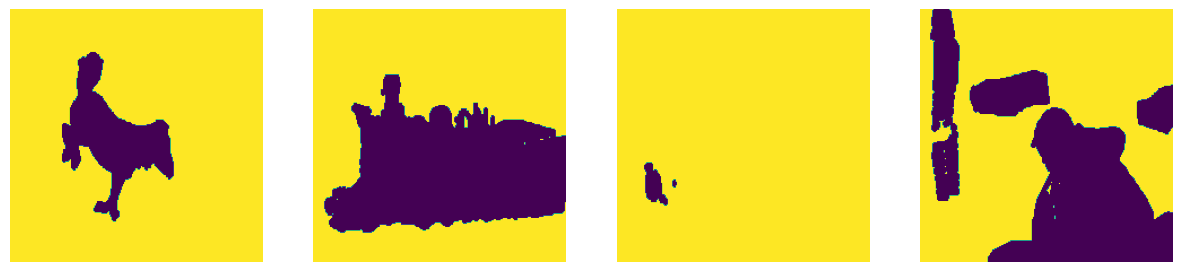

In [6]:
# Function to convert tensor to numpy array
def tensor_to_numpy(tensor):
    if tensor.dim() == 3:  # For image tensors (C, H, W)
        return tensor.permute(1, 2, 0).numpy()
    elif tensor.dim() == 2:  # For mask tensors (H, W)
        return tensor.numpy()
    else:
        raise ValueError("Unexpected tensor dimensions")

# Function to visualize images
def visualize_images(data_loader):
    # Get a batch of images and masks from the DataLoader
    images, masks = next(iter(data_loader))
    
    # Number of images to display
    num_images = min(4, len(images))
    
    # Create a figure with subplots
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    # Loop through the batch and display each image and mask
    for i in range(num_images):
        img = tensor_to_numpy(images[i])
        mask = tensor_to_numpy(masks[i])
#         unique, frequency = np.unique(mask, 
#                               return_counts = True)
#         # print unique values array
#         print("Unique Values:", 
#               unique)

#         # print frequency array
#         print("Frequency Values:",
#               frequency)
        
        # Plot the image
        axes[i].imshow(mask)
        axes[i].axis('off')  # Hide axes
    
    plt.show()

# Example usage with your DataLoader
visualize_images(train_loader)  # Or val_loader for validation images

In [7]:
class ViT_Segmentation(nn.Module):
    def __init__(self, img_size=224, patch_size=16, num_classes=2):
        super(ViT_Segmentation, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.vit.head = nn.Identity()  # Remove the classification head
        
        # Define the new head for segmentation
        self.segmentation_head = nn.Conv2d(in_channels=768, out_channels=num_classes, kernel_size=1)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

    def forward(self, x):
        # Extract features
        x = self.vit.forward_features(x)
        
        # Print the shape to debug
        # print("Shape after forward_features:", x.shape)

        # Calculate dimensions for reshaping
        batch_size, num_tokens, embed_dim = x.shape
        seq_len = int(self.img_size / self.patch_size)  # This should be 14 for patch_size 16 and img_size 224
        
        # Compute the correct spatial dimensions
        height = width = seq_len

        # Reshape features to match spatial dimensions
        x = x[:, 1:, :]  # Exclude the class token
        x = x.permute(0, 2, 1).reshape(batch_size, embed_dim, height, width)

        # Upsample to match the original input size
        x = nn.functional.interpolate(x, size=(self.img_size, self.img_size), mode='bilinear', align_corners=False)
        
        # Apply segmentation head
        x = self.segmentation_head(x)
        return x

# Instantiate and move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT_Segmentation(img_size=224, patch_size=16, num_classes=2).to(device)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [8]:
mod = timm.create_model('vit_base_patch16_224', pretrained=True)
mod

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [9]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        # Ensure outputs and masks have the same dimensions
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            # Ensure outputs and masks have the same dimensions
            loss = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch 1/10, Train Loss: 0.3248, Val Loss: 0.2669
Epoch 2/10, Train Loss: 0.2227, Val Loss: 0.2552
Epoch 3/10, Train Loss: 0.1725, Val Loss: 0.2393
Epoch 4/10, Train Loss: 0.1315, Val Loss: 0.2584
Epoch 5/10, Train Loss: 0.1170, Val Loss: 0.2466
Epoch 6/10, Train Loss: 0.1007, Val Loss: 0.2550
Epoch 7/10, Train Loss: 0.0923, Val Loss: 0.2896
Epoch 8/10, Train Loss: 0.0872, Val Loss: 0.3004
Epoch 9/10, Train Loss: 0.0833, Val Loss: 0.3056
Epoch 10/10, Train Loss: 0.0975, Val Loss: 0.3004


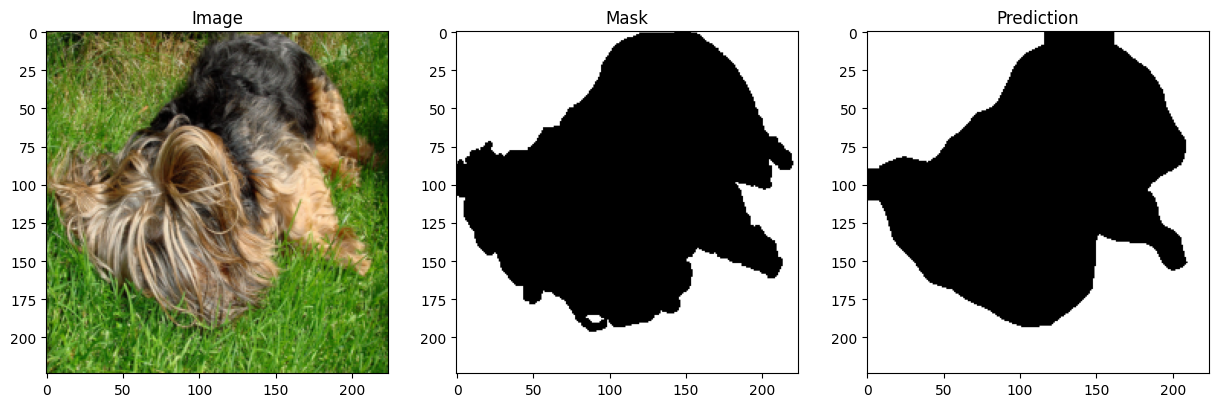

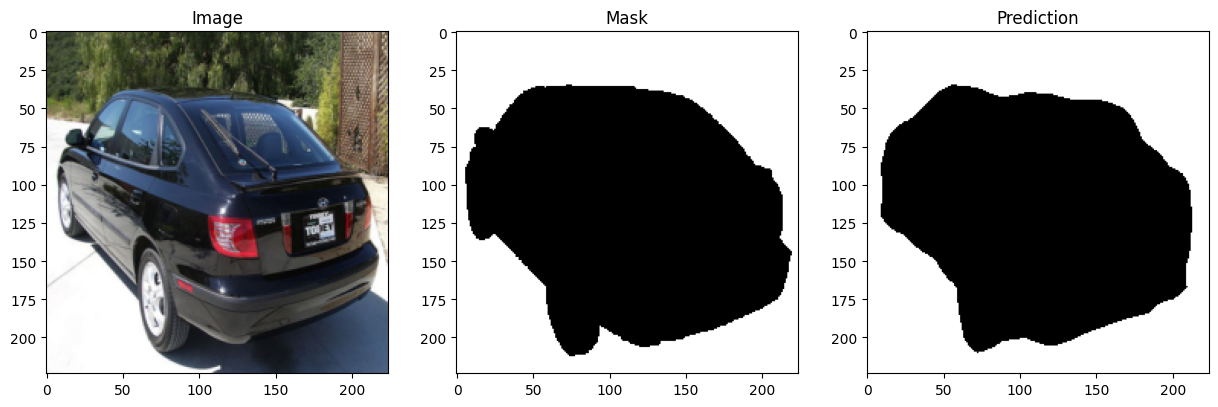

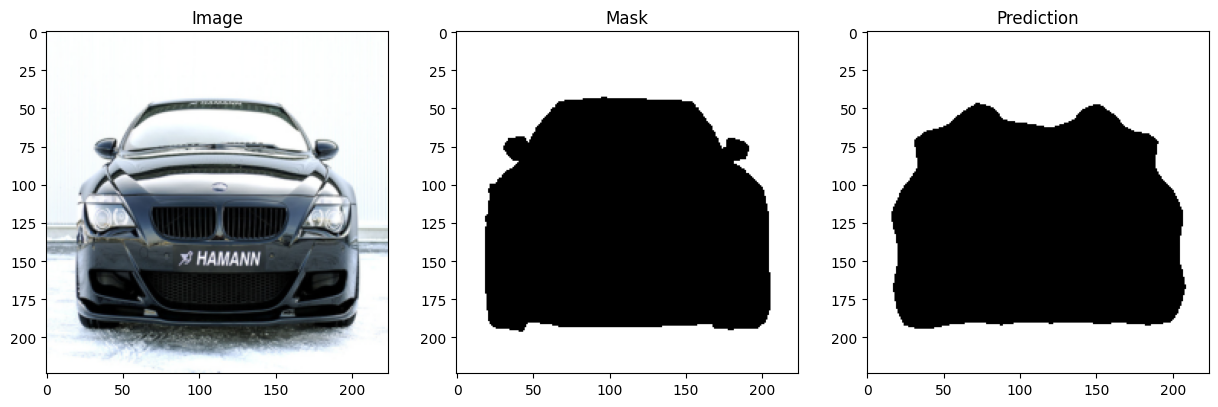

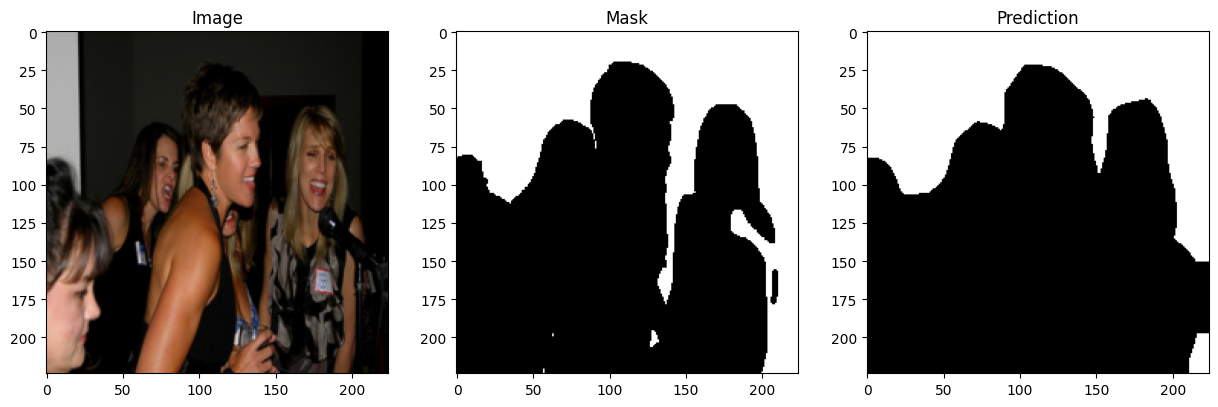

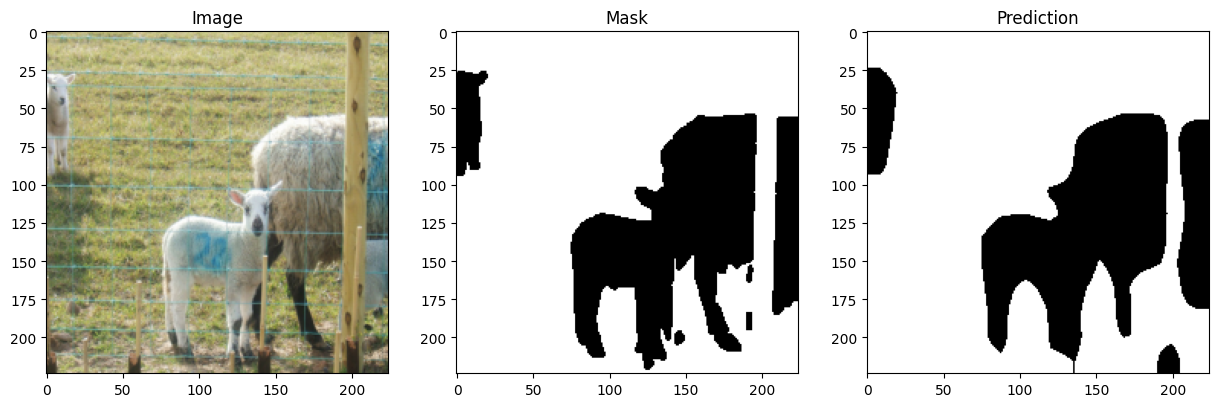

In [13]:
model.eval()
count = 0
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        outputs = torch.argmax(outputs, dim=1).cpu().numpy()
        masks = masks.cpu().numpy()
        
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(images[0].permute(1, 2, 0).cpu())
        axs[0].set_title('Image')
        axs[1].imshow(masks[0], cmap='gray')
        axs[1].set_title('Mask')
        axs[2].imshow(outputs[0], cmap='gray')
        axs[2].set_title('Prediction')
        plt.show()
        count += 1
        if count == 5:
            break